# Notebook 2: Linear regression and random forests with scikit-learn

Now that we have prepared our data we can start building machine learning models.

We will start with the simplest model: Linear regression

In [76]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [163]:
DATADIR = '/local/S.Rasp/ML-Workshop-Data/'

In [162]:
def create_sub(preds, fn=None):
    df =  pd.DataFrame({'Id': range(len(preds)), 'Expected': preds})
    if fn is not None: df.to_csv(DATADIR + fn, index=False)
    return df

In [177]:
# Load the data
with open('./data/preproc_data.pkl', 'rb') as f:
    X_train, y_train, X_valid, y_valid, X_test = pickle.load(f)
with open('./data/dfs.pkl', 'rb') as f:
    df_train, df_test = pickle.load(f)

## Linear regression

### Compute baseline mse

In [152]:
def mse(y_true, y_pred): return ((y_true - y_pred)**2).mean()

In [153]:
mse(y_valid, df_train.t2m_fc_mean[df_train.time >= '2015-01-01'])

4.135858792431942

### sklearn API

All sklearn models work in exactly the same way.

In [154]:
from sklearn.linear_model import LinearRegression

In [155]:
# Create the model object
lr = LinearRegression()

In [156]:
# Fit the model parameters with the training data
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [157]:
X_train.columns

Index(['t2m_fc_mean', 'orog', 'station_alt', 'station_lat', 'station_lon',
       'u_pl500_fc_mean', 'v_pl500_fc_mean', 'gh_pl500_fc_mean',
       'u_pl850_fc_mean', 'v_pl850_fc_mean', 'q_pl850_fc_mean', 'cape_fc_mean',
       'sp_fc_mean', 'tcc_fc_mean', 'sshf_fc_mean', 'slhf_fc_mean',
       'u10_fc_mean', 'v10_fc_mean', 'ssr_fc_mean', 'str_fc_mean',
       'd2m_fc_mean', 'sm_fc_mean'],
      dtype='object')

In [158]:
lr.coef_

array([ 5.20734246,  0.53522914, -0.9193415 , -0.14865423, -0.10651631,
        0.01482758, -0.06200976,  0.22355911,  0.08053755, -0.01852129,
        0.14741519, -0.03510716, -0.17207246,  0.17164729,  0.54843072,
       -0.03918102, -0.06724854,  0.13348599,  0.77616008,  0.21138807,
        0.61088598, -0.04088925])

In [159]:
lr.intercept_

7.448795068185583

In [160]:
# Make predictions for validation set
preds = lr.predict(X_valid)

In [58]:
mse(preds, y_valid)

3.2422963614329707

In [164]:
# Submit to Kaggle
df_sub = create_sub(lr.predict(X_test), 'lr.csv'); df_sub.head()

,Id,Expected
0,0,4.195768
1,1,1.528290
2,2,1.475483
3,3,4.318616
4,4,2.337542


### The R$^2$ score

The R$^2$ score is a common skill metric in machine learning: https://en.wikipedia.org/wiki/Coefficient_of_determination

In [59]:
lr.score(X_valid, y_valid)

0.9187372901848856

In [93]:
def print_scores(m, X_train=X_train, X_valid=X_valid):
    print('Train R2 = ', m.score(X_train, y_train), 
          ', Valid R2 = ', m.score(X_valid, y_valid), ', Valid MSE = ', 
          mse(m.predict(X_valid), y_valid))

In [94]:
print_scores(lr)

Train R2 =  0.9319430866570234 , Valid R2 =  0.9187372901848856 , Valid MSE =  3.2422963614329707


## Decicion trees

Linear regression improves the score but we can do better. One very common machine learning algorithm are decision trees. They are capable of representing non-linear relationships. In scikit-learn we can use the exact same API as before.

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import display
import IPython, graphviz, re

### Visualize a tree

In [20]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ From fast.ai machine learning course.
    Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

Let's start with a very shallow tree which we can visualize.

In [30]:
dt = DecisionTreeRegressor(max_depth=3)

In [31]:
%time dt.fit(X_train, y_train)

CPU times: user 5.58 s, sys: 32 ms, total: 5.62 s
Wall time: 5.61 s


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

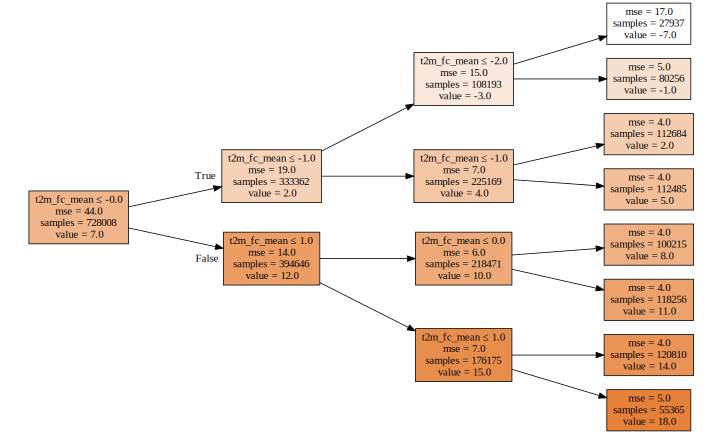

In [33]:
draw_tree(dt, df_train.drop(['t2m_obs', 'time', 'station'], 1))

### Build a full tree

Now let's actually build a complicated tree.

In [34]:
dt = DecisionTreeRegressor()

In [35]:
%time dt.fit(X_train, y_train)

CPU times: user 34 s, sys: 68 ms, total: 34.1 s
Wall time: 34.1 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [42]:
print_scores(dt)

Train R2 =  1.0 , Valid R2 =  0.8439342628856448 , Valid MSE =  6.226858207676123


So we have a perfect score on the training dataset, but a pretty awful score on the validation set. This is an extreme case of overfitting!

### Reduce the complexity of the tree

In [46]:
dt = DecisionTreeRegressor(min_samples_leaf=200)

In [47]:
%time dt.fit(X_train, y_train)

CPU times: user 21.8 s, sys: 20 ms, total: 21.8 s
Wall time: 21.8 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=200,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [48]:
print_scores(dt)

Train R2 =  0.939008732905577 , Valid R2 =  0.9112729295089091 , Valid MSE =  3.540116474929169


The overfitting is less bad now but we still cannot get a better score than with linear regression. We need to do better!

## Random forests

In [62]:
from sklearn.ensemble import RandomForestRegressor

### Fit a sample model

Now we are fitting several decision trees. This can be done in parallel by several processors. `n_jobs = -1` uses all available processors.

In [63]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)

In [64]:
%time rf.fit(X_train, y_train)

CPU times: user 4min 21s, sys: 420 ms, total: 4min 21s
Wall time: 28.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [65]:
print_scores(rf)

Train R2 =  0.9924217592928964 , Valid R2 =  0.9175357921923839 , Valid MSE =  3.2902348633390006


### Hyperparameters

Again we need to tune the hyperparameters to combat overfitting

#### min_samples_leaf

In [66]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, min_samples_leaf=100)

In [67]:
%time rf.fit(X_train, y_train)

CPU times: user 2min 58s, sys: 84 ms, total: 2min 58s
Wall time: 18.3 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [68]:
print_scores(rf)

Train R2 =  0.9468820244229854 , Valid R2 =  0.919418313977026 , Valid MSE =  3.2151242308416883


#### n_estimators

In [165]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [166]:
%time rf.fit(X_train, y_train)

CPU times: user 20min 48s, sys: 424 ms, total: 20min 48s
Wall time: 1min 7s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [167]:
print_scores(rf)

Train R2 =  0.9759219336139724 , Valid R2 =  0.9238195996984498 , Valid MSE =  3.039517575431469


Now we are significantly better than linear regression. Success!!! But why?

In [168]:
# Submit to Kaggle
df_sub = create_sub(rf.predict(X_test), 'rf.csv'); df_sub.head()

,Id,Expected
0,0,3.784826
1,1,1.575518
2,2,0.445792
3,3,3.970306
4,4,2.550068


## Feature importance


In [72]:
rf.feature_importances_

array([0.93873543, 0.00185988, 0.00731034, 0.00478461, 0.00223443,
       0.0021533 , 0.00214281, 0.00321241, 0.00229144, 0.00209551,
       0.00322345, 0.00196014, 0.00138399, 0.00263572, 0.00224626,
       0.00176189, 0.00234914, 0.00211757, 0.00187498, 0.00214127,
       0.01019709, 0.00128832])

In [73]:
fi_df = pd.DataFrame(
    data={'Feature': X_train.columns, 'Feature importance': rf.feature_importances_}, 
    columns = ['Feature', 'Feature importance']
)

In [82]:
fi_df.sort_values('Feature importance', inplace=True, ascending=False)

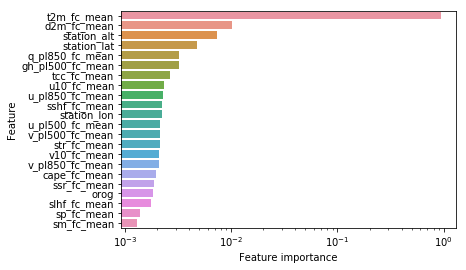

In [83]:
sns.barplot(data=fi_df, x='Feature importance', y='Feature')
plt.xscale('log')

There some other really cool ways of interpreting a random forest. For more information check out this notebook: https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb

## Your turn

Again, here are some challenges for all of you that are bored ;)

1. The different stations have very different characteristics. Try building a model (e.g. linear regression) for each station individually. See if you can improve the validation and test score.
2. Try adding some time information as a feature. Does this improve the forecast?
3. Try to get as good a score as possible. Be creative and use Google!

### Build a LR model for each station individually

In [169]:
split_date = '2015-01-01'

In [178]:
stations_train = df_train.station[df_train.time < split_date]
stations_valid = df_train.station[df_train.time >= split_date]
stations_test = df_test.station

In [171]:
%%time
models = {}
for s in stations_train.unique():
    m = LinearRegression()
    m.fit(X_train[stations_train == s], y_train[stations_train == s])
    models[s] = m

CPU times: user 40.9 s, sys: 644 ms, total: 41.6 s
Wall time: 4.17 s


In [172]:
preds = np.zeros(len(y_valid))
for s in stations_valid.unique():
    s_idxs = stations_valid == s
    if s in stations_train.unique():
        preds[s_idxs] = models[s].predict(X_valid[s_idxs])
    else:
        preds[s_idxs] = lr.predict(X_valid[s_idxs])

In [173]:
mse(preds, y_valid)

2.4853897742399758

In [176]:
len(X_test), X_test.shape

(182218, (182218, 22))

In [179]:
test_preds = np.zeros(len(X_test))
for s in stations_test.unique():
    s_idxs = stations_test == s
    if s in stations_train.unique():
        test_preds[s_idxs] = models[s].predict(X_test[s_idxs])
    else:
        test_preds[s_idxs] = lr.predict(X_test[s_idxs])

In [180]:
# Submit to Kaggle
df_sub = create_sub(test_preds, 'lr_local.csv'); df_sub.head()

,Id,Expected
0,0,3.681001
1,1,1.831077
2,2,1.240477
3,3,3.521409
4,4,2.341089


In [192]:
stations_train.unique()

array([    3,    44,    71,    73,    78,    91,   102,   131,   142,
         150,   151,   154,   164,   167,   183,   191,   198,   217,
         222,   232,   257,   259,   282,   294,   298,   303,   314,
         320,   326,   330,   342,   348,   368,   377,   390,   399,
         400,   403,   410,   420,   427,   430,   433,   445,   450,
         460,   535,   555,   591,   596,   603,   617,   656,   662,
         691,   701,   704,   722,   755,   757,   766,   817,   840,
         853,   856,   863,   867,   880,   891,   896,   917,   953,
         954,   963,   979,   983,   991,  1001,  1048,  1050,  1051,
        1052,  1072,  1078,  1103,  1107,  1161,  1197,  1200,  1207,
        1214,  1224,  1228,  1255,  1262,  1266,  1270,  1279,  1297,
        1300,  1303,  1327,  1332,  1341,  1346,  1357,  1358,  1411,
        1420,  1424,  1443,  1451,  1468,  1473,  1504,  1526,  1544,
        1550,  1580,  1584,  1587,  1590,  1602,  1605,  1612,  1639,
        1645,  1666,

In [191]:
stations_test

0            44
1            71
2            73
3            78
4            91
5           102
6           125
7           131
8           142
9           150
10          151
11          154
12          161
13          164
14          167
15          183
16          191
17          198
18          217
19          222
20          232
21          257
22          259
23          282
24          294
25          298
26          303
27          314
28          320
29          330
          ...  
182188     7373
182189     7374
182190     7389
182191     7393
182192     7394
182193     7395
182194     7396
182195     7403
182196     7410
182197     7412
182198     7419
182199     7420
182200     7424
182201     7427
182202     7428
182203     7431
182204     7432
182205    13670
182206    13674
182207    13675
182208    13696
182209    13700
182210    13710
182211    13711
182212    13713
182213    13777
182214    15000
182215    15207
182216    15444
182217    15555
Name: station, Length: 1

In [190]:
df_sub.Expected

0         3.681001e+00
1         1.831077e+00
2         1.240477e+00
3         3.521409e+00
4         2.341089e+00
5         6.505240e+00
6         2.837891e+00
7         3.310848e+00
8         2.905298e+00
9         2.865319e+00
10        2.205980e+00
11        2.814209e+00
12        2.481154e+00
13        1.906980e-01
14        5.632324e-01
15       -3.134872e+09
16        2.451583e+00
17        2.879304e+00
18        3.960621e+00
19        2.474303e+00
20        3.074297e+00
21        3.600873e+00
22        3.863048e+00
23        3.159507e+00
24        4.462692e+00
25        8.775873e-01
26        2.341722e+00
27        7.897204e-01
28        2.877225e+00
29        2.700570e+00
              ...     
182188    4.202196e+00
182189   -8.804534e-01
182190   -1.069839e+00
182191   -2.314072e+00
182192   -3.900060e+00
182193   -4.519597e+00
182194   -2.626953e+00
182195   -5.896702e+00
182196   -3.148272e+00
182197   -5.182364e+00
182198   -1.335039e+00
182199   -2.220777e+00
182200   -6

In [186]:
(df_sub.Expected < 50).mean()

1.0

### Add month as information

In [142]:
month = pd.DatetimeIndex(df_train['time']).month

In [143]:
X_train_month = X_train.copy()
X_valid_month = X_valid.copy()

In [144]:
X_train_month['month'] = month[df_train.time < split_date]
X_valid_month['month'] = month[df_train.time >= split_date]

In [145]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [146]:
%time rf.fit(X_train_month, y_train)

CPU times: user 21min 17s, sys: 504 ms, total: 21min 18s
Wall time: 1min 9s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [147]:
print_scores(rf, X_train_month, X_valid_month)

Train R2 =  0.97601687453504 , Valid R2 =  0.9242793509228924 , Valid MSE =  3.021173986772311


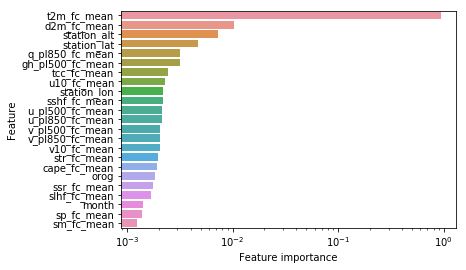

In [149]:
fi_df = pd.DataFrame(
    data={'Feature': X_train_month.columns, 'Feature importance': rf.feature_importances_}, 
    columns = ['Feature', 'Feature importance']
)
fi_df.sort_values('Feature importance', inplace=True, ascending=False)
sns.barplot(data=fi_df, x='Feature importance', y='Feature')
plt.xscale('log')